In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def brownian_bridge(t0, tT, x0, xT, n_steps=100):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X

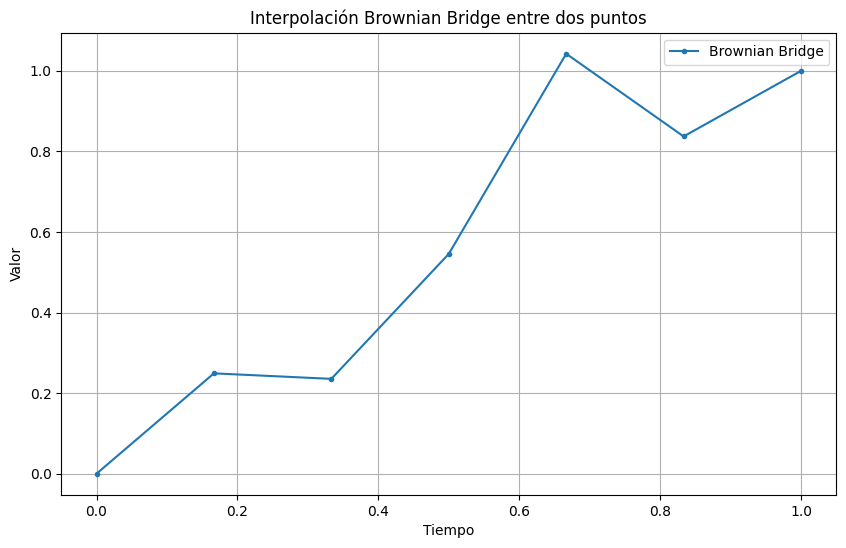

In [3]:
# Parámetros del Brownian Bridge
t0 = 0      # Tiempo inicial
tT = 1      # Tiempo final
x0 = 0      # Valor en t0
xT = 1      # Valor en tT
n_steps = 7  # Número de pasos en la interpolación

# Generar interpolación usando Brownian Bridge
t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
# t, X = interpolador_hermite(np.array([1,5,2,6]), 10)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(t, X,".-", label='Brownian Bridge')
# plt.scatter([1,2,3,4,5],np.array([1,3,2,7,5]), color='red', zorder=5, label='Puntos inicial y final')
plt.title('Interpolación Brownian Bridge entre dos puntos')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
import numpy as np
import random
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=25, b=0.6):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []
    pendientes = []
    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)
        pendientes.append(pendiente)
    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4 and np.all(np.array(pendientes[i:]) >= 0): 
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm = v1
        else:
             v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm = v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

In [96]:
def J_bivariante(X,Y,corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))
    ff2 = np.angle(np.fft.rfft(Y))
    if corte:
        print(len(ff1), len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        print(len(ff1), len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [47]:
def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps+2)
        if i == 0:
            t_list = np.concatenate((t_list, t[:]))
            X_list = np.concatenate((X_list, X[:]))
        else:
            t_list = np.concatenate((t_list, t[1:]))
            X_list = np.concatenate((X_list, X[1:]))          
    return t_list, X_list

In [8]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

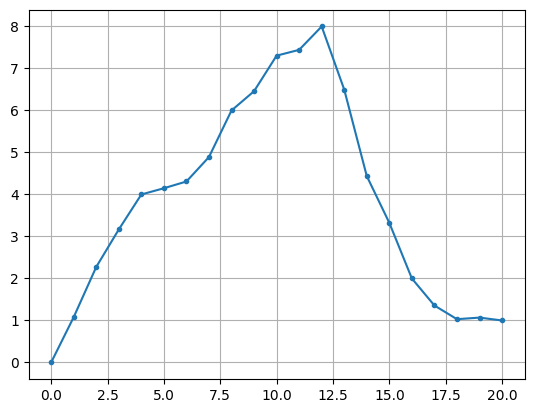

In [49]:
g = [0, 4, 6, 8, 2, 1]
# x, g = interpolador(g, 'herm', 14)
x_interp, gg = interpolador_estocastico(g, 3)
# plt.plot(x, g)
# plt.xlim(0,10)
plt.plot(gg, '.-')
plt.grid()
# print(J_univariante(gg, 1, True)[0])

In [50]:
import numpy as np

def lorenz_system(x0, y0, z0, sigma=10, rho=1005, beta=8/3, dt=0.001, steps=10000):
    """
    Simula el sistema de Lorenz usando el método de Runge-Kutta de cuarto orden.
    
    Args:
    x0, y0, z0 (float): Condiciones iniciales para x, y, z.
    sigma, rho, beta (float): Parámetros del sistema de Lorenz.
    dt (float): Tamaño del paso de tiempo.
    steps (int): Número de pasos de simulación.
    
    Returns:
    tuple: Arrays de x, y, y z con las trayectorias del sistema de Lorenz.
    """
    # Inicializar arrays
    x = np.empty(steps)
    y = np.empty(steps)
    z = np.empty(steps)
    
    # Condiciones iniciales
    x[0], y[0], z[0] = x0, y0, z0
    
    # Integración de Runge-Kutta de cuarto orden
    for i in range(1, steps):
        # Definir las funciones derivadas
        dx = lambda x, y: sigma * (y - x)
        dy = lambda x, y, z: x * (rho - z) - y
        dz = lambda x, y, z: x * y - beta * z

        # Calcular los k para Runge-Kutta
        kx1 = dx(x[i-1], y[i-1]) * dt
        ky1 = dy(x[i-1], y[i-1], z[i-1]) * dt
        kz1 = dz(x[i-1], y[i-1], z[i-1]) * dt
        
        kx2 = dx(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1) * dt
        ky2 = dy(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1, z[i-1] + 0.5 * kz1) * dt
        kz2 = dz(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1, z[i-1] + 0.5 * kz1) * dt
        
        kx3 = dx(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2) * dt
        ky3 = dy(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2, z[i-1] + 0.5 * kz2) * dt
        kz3 = dz(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2, z[i-1] + 0.5 * kz2) * dt
        
        kx4 = dx(x[i-1] + kx3, y[i-1] + ky3) * dt
        ky4 = dy(x[i-1] + kx3, y[i-1] + ky3, z[i-1] + kz3) * dt
        kz4 = dz(x[i-1] + kx3, y[i-1] + ky3, z[i-1] + kz3) * dt
        
        # Actualizar valores de x, y, z
        x[i] = x[i-1] + (kx1 + 2 * kx2 + 2 * kx3 + kx4) / 6
        y[i] = y[i-1] + (ky1 + 2 * ky2 + 2 * ky3 + ky4) / 6
        z[i] = z[i-1] + (kz1 + 2 * kz2 + 2 * kz3 + kz4) / 6
    
    return x, y, z


In [116]:
Js= []
Js_intp=[]
for rho in [28, 99.65, 160, 100.5, 350]:
    xs, ys, zs = lorenz_system(3.083289188624795, 1.792622709328299 , 1.34, sigma=10, rho=rho, beta=8/3, dt=0.01, steps=10000)
    Js_intp.append(J_bivariante(interpolador_estocastico(xs,1)[1],interpolador_estocastico(ys,1)[1],True))
    Js.append(J_bivariante(xs,ys,False))

10000 10000
9600 9600
10000 10000
9600 9600
10000 10000
9600 9600
10000 10000
9600 9600
10000 10000
9600 9600


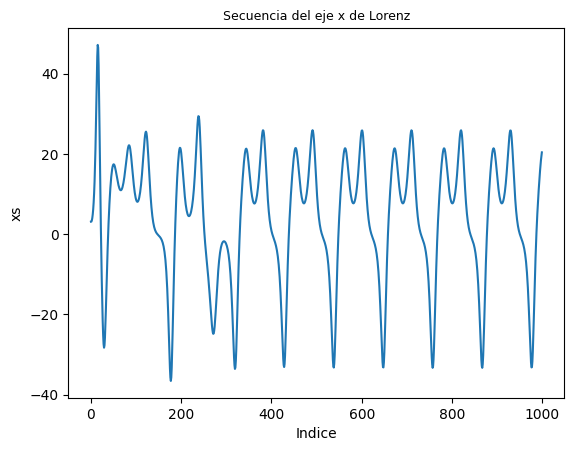

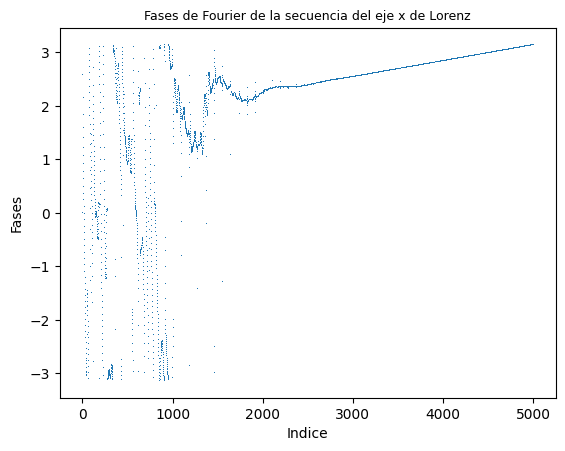

0.06035635317344612


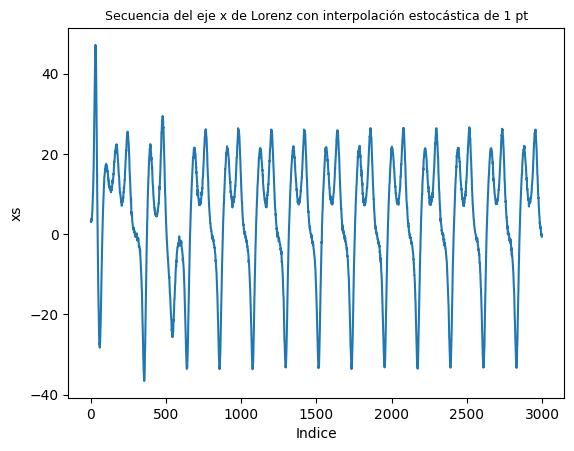

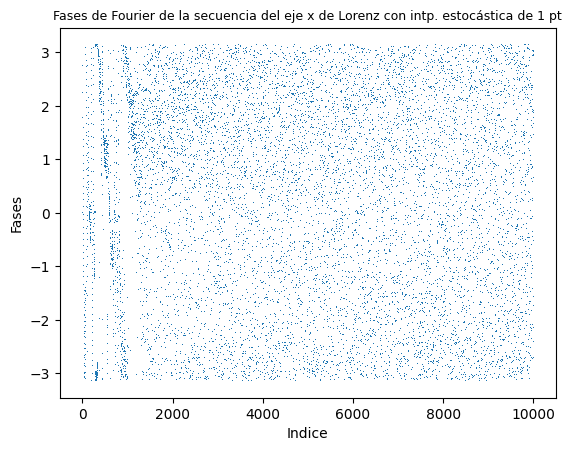

0.9176257032594798


In [115]:
xs, ys, zs = lorenz_system(3.083289188624795, 1.792622709328299 , 1.34, sigma=10, rho=100.5, beta=8/3, dt=0.01, steps=10000)
plt.plot(xs[:1000])
plt.xlabel('Indice')
plt.ylabel('xs')
plt.title('Secuencia del eje x de Lorenz', fontsize=9)
plt.show()
plt.plot(np.angle(np.fft.rfft(xs)), ',')
plt.title('Fases de Fourier de la secuencia del eje x de Lorenz', fontsize=9)
plt.xlabel('Indice')
plt.ylabel('Fases')
plt.show()
print(J_univariante(xs,1,True)[0])
xs_intp = interpolador_estocastico(xs,1)[1]
plt.plot(xs_intp[:3000])
plt.xlabel('Indice')
plt.ylabel('xs')
plt.title('Secuencia del eje x de Lorenz con interpolación estocástica de 1 pt', fontsize=9)
plt.show()
plt.plot(np.angle(np.fft.rfft(xs_intp)),',')
plt.title('Fases de Fourier de la secuencia del eje x de Lorenz con intp. estocástica de 1 pt', fontsize=9)
plt.xlabel('Indice')
plt.ylabel('Fases')
plt.show()
print(J_univariante(xs_intp,1,False)[0])

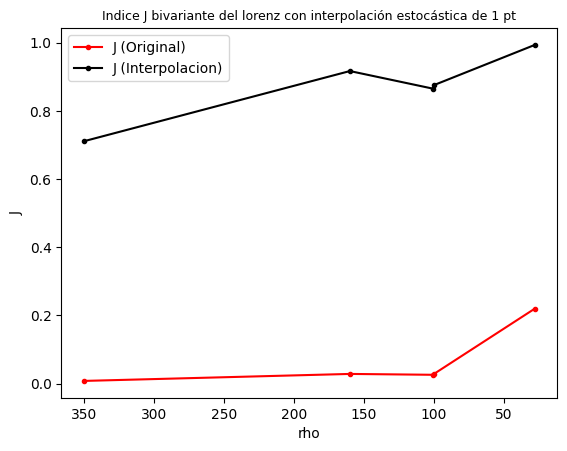

In [118]:
plt.plot([28, 99.65, 100.5, 160, 350], Js, '.-', color = 'red', label = 'J (Original)')
plt.plot([28, 99.65, 100.5, 160, 350],Js_intp, '.-', color = 'black',label = 'J (Interpolacion)')
plt.xlabel('rho')
plt.ylabel('J')
plt.title('Indice J bivariante del lorenz con interpolación estocástica de 1 pt', fontsize=9)
plt.gca().invert_xaxis()
plt.legend()